<font size="4">
    
# Cutting and preprocessing tiles from a histological image.

In this tutorial we go through how to use `histoprep` to cut tiles from a large histological slide and perform basic preprocessing.

#### Install `histoprep`
First remeber to install `HistoPrep` on your device with.

```
git clone https://github.com/jopo666/HistoPrep
cd HistoPrep
pip install -r requirements.txt
```

#### Download data

First we need to find some publicly available data for you to use. The people of Digital Pathology association have listed freely available repositories [here](https://digitalpathologyassociation.org/whole-slide-imaging-repository).

You try the notebook with your own slides by editing the `slide_path` argument. One easy way is to just run the below script to use one of the example slides hosted by [openslide](https://openslide.org).

In [ ]:
!mkdir $HOME/test_data
!curl http://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/JP2K-33003-2.svs -o $HOME/test_data/heart.svs
slide_path = !echo $HOME/test_data/data/heart.svs
slide_path = slide_path[0]

## Cutting tiles


Now as we have our slide to test with, we can continue to the fun part. Let's first import `histoprep`.

In [1]:
import histoprep as hp
slide_path = '/data/heart.svs'

`Cutter()` object automatically discards background on the slide based on the thumbnail image. For this reason we should see what thumbnail `downsample`s the image has.

In [2]:
hp.available_downsamples(slide_path)

Downsample      Dimensions     
1               (32671, 47076) 
4               (8167, 11769)  
16              (2041, 2942)   


First downsample `1` is the whole image. If this would be turned into an `numpy.ndarray` it would have 4600 million elements... That wouldn't be nice, but luckily we can work with the thumbnails that have reasonable dimensions.

When a `Cutter()` object is defined the following tasks are executed.

   1. Divided the whole image into tiles based on the `width` and `overlap` arguments. 
   2. Create a background mask from a thumbnail (based on the `downsample` argument).
   3. Go through all the tiles as discard those that have more background than allowed by the `max_background` argument.
   
Let's try it out!

In [3]:
import time

tic = time.time()

cutter = hp.Cutter(
    slide_path=slide_path,
    width=1024,
    overlap=0.2,
    downsample=16,
    max_background=0.6
)

print(f'That took {time.time()-tic:.4f} seconds!')

That took 1.3951 seconds!


Now the slide is divided into tiles with minimum 40% tissue! On my macbook that took under a second, but the time depends on the slide, downsample and wheter the thumbnail must be created.

Let's take a look at the results.

In [4]:
cutter.summary()

heart
  Tile width: 1024
  Tile overlap: 0.2
  Saturation threshold: 54
  Max background: 0.6
  Total number of tiles: 2320
  After background filtering: 655


As we can see, 28% of the detected tiles contained enough tissue. `Cutter` object has also some simple plotting capabilities! Let's first take a look at the selected tiles.

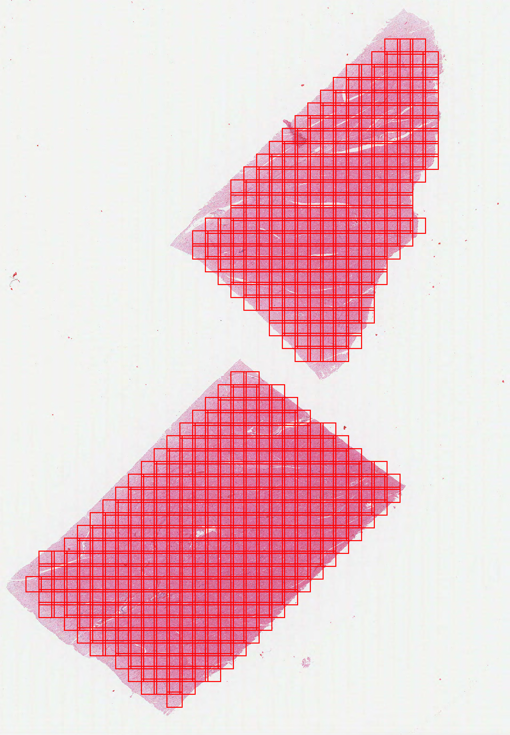

In [5]:
cutter.plot_tiles()

As you can see the that didn't work quite as we expected. For some reason the tiles do not cover the whole tissue. To debug, let's take a look at our `tissue_mask`.

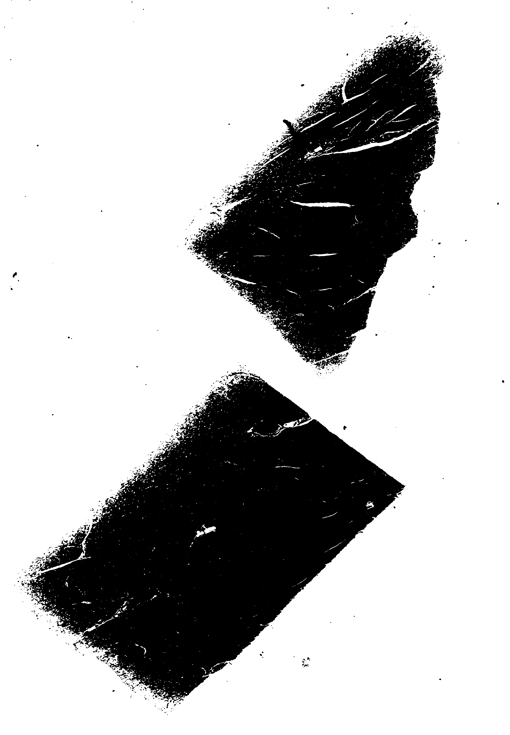

In [6]:
cutter.plot_tissue_mask()

As we can see the tissue isn't detected correctly. This is because we were lazy, and didn't define `sat_thresh` for the `Cutter()`.

Background is detected by looking at the saturation transformation of the image. Saturation is great for tissue detection as we can simply threshold the value to take a binary mask. When we don't provide `Cutter()` with a saturation value, the value is found by minimizing the weighted within-class variance, otherwise known as [Otsu's method](https://ieeexplore.ieee.org/document/4310076). This method is nice as it requires one less input from the end-user, but in tissue detection **the selected threshold is often too high** leading to situations like this.

How can we then choose a better value than the one selected by Otsu's method? This can be  easily done by simply trying different thresholds and seeing what works best for our data! With `histopre` this can be done with one command.

Saturation thresholds:

original   5       10      15   
   20      30      40      50   
   60      80     100     120   


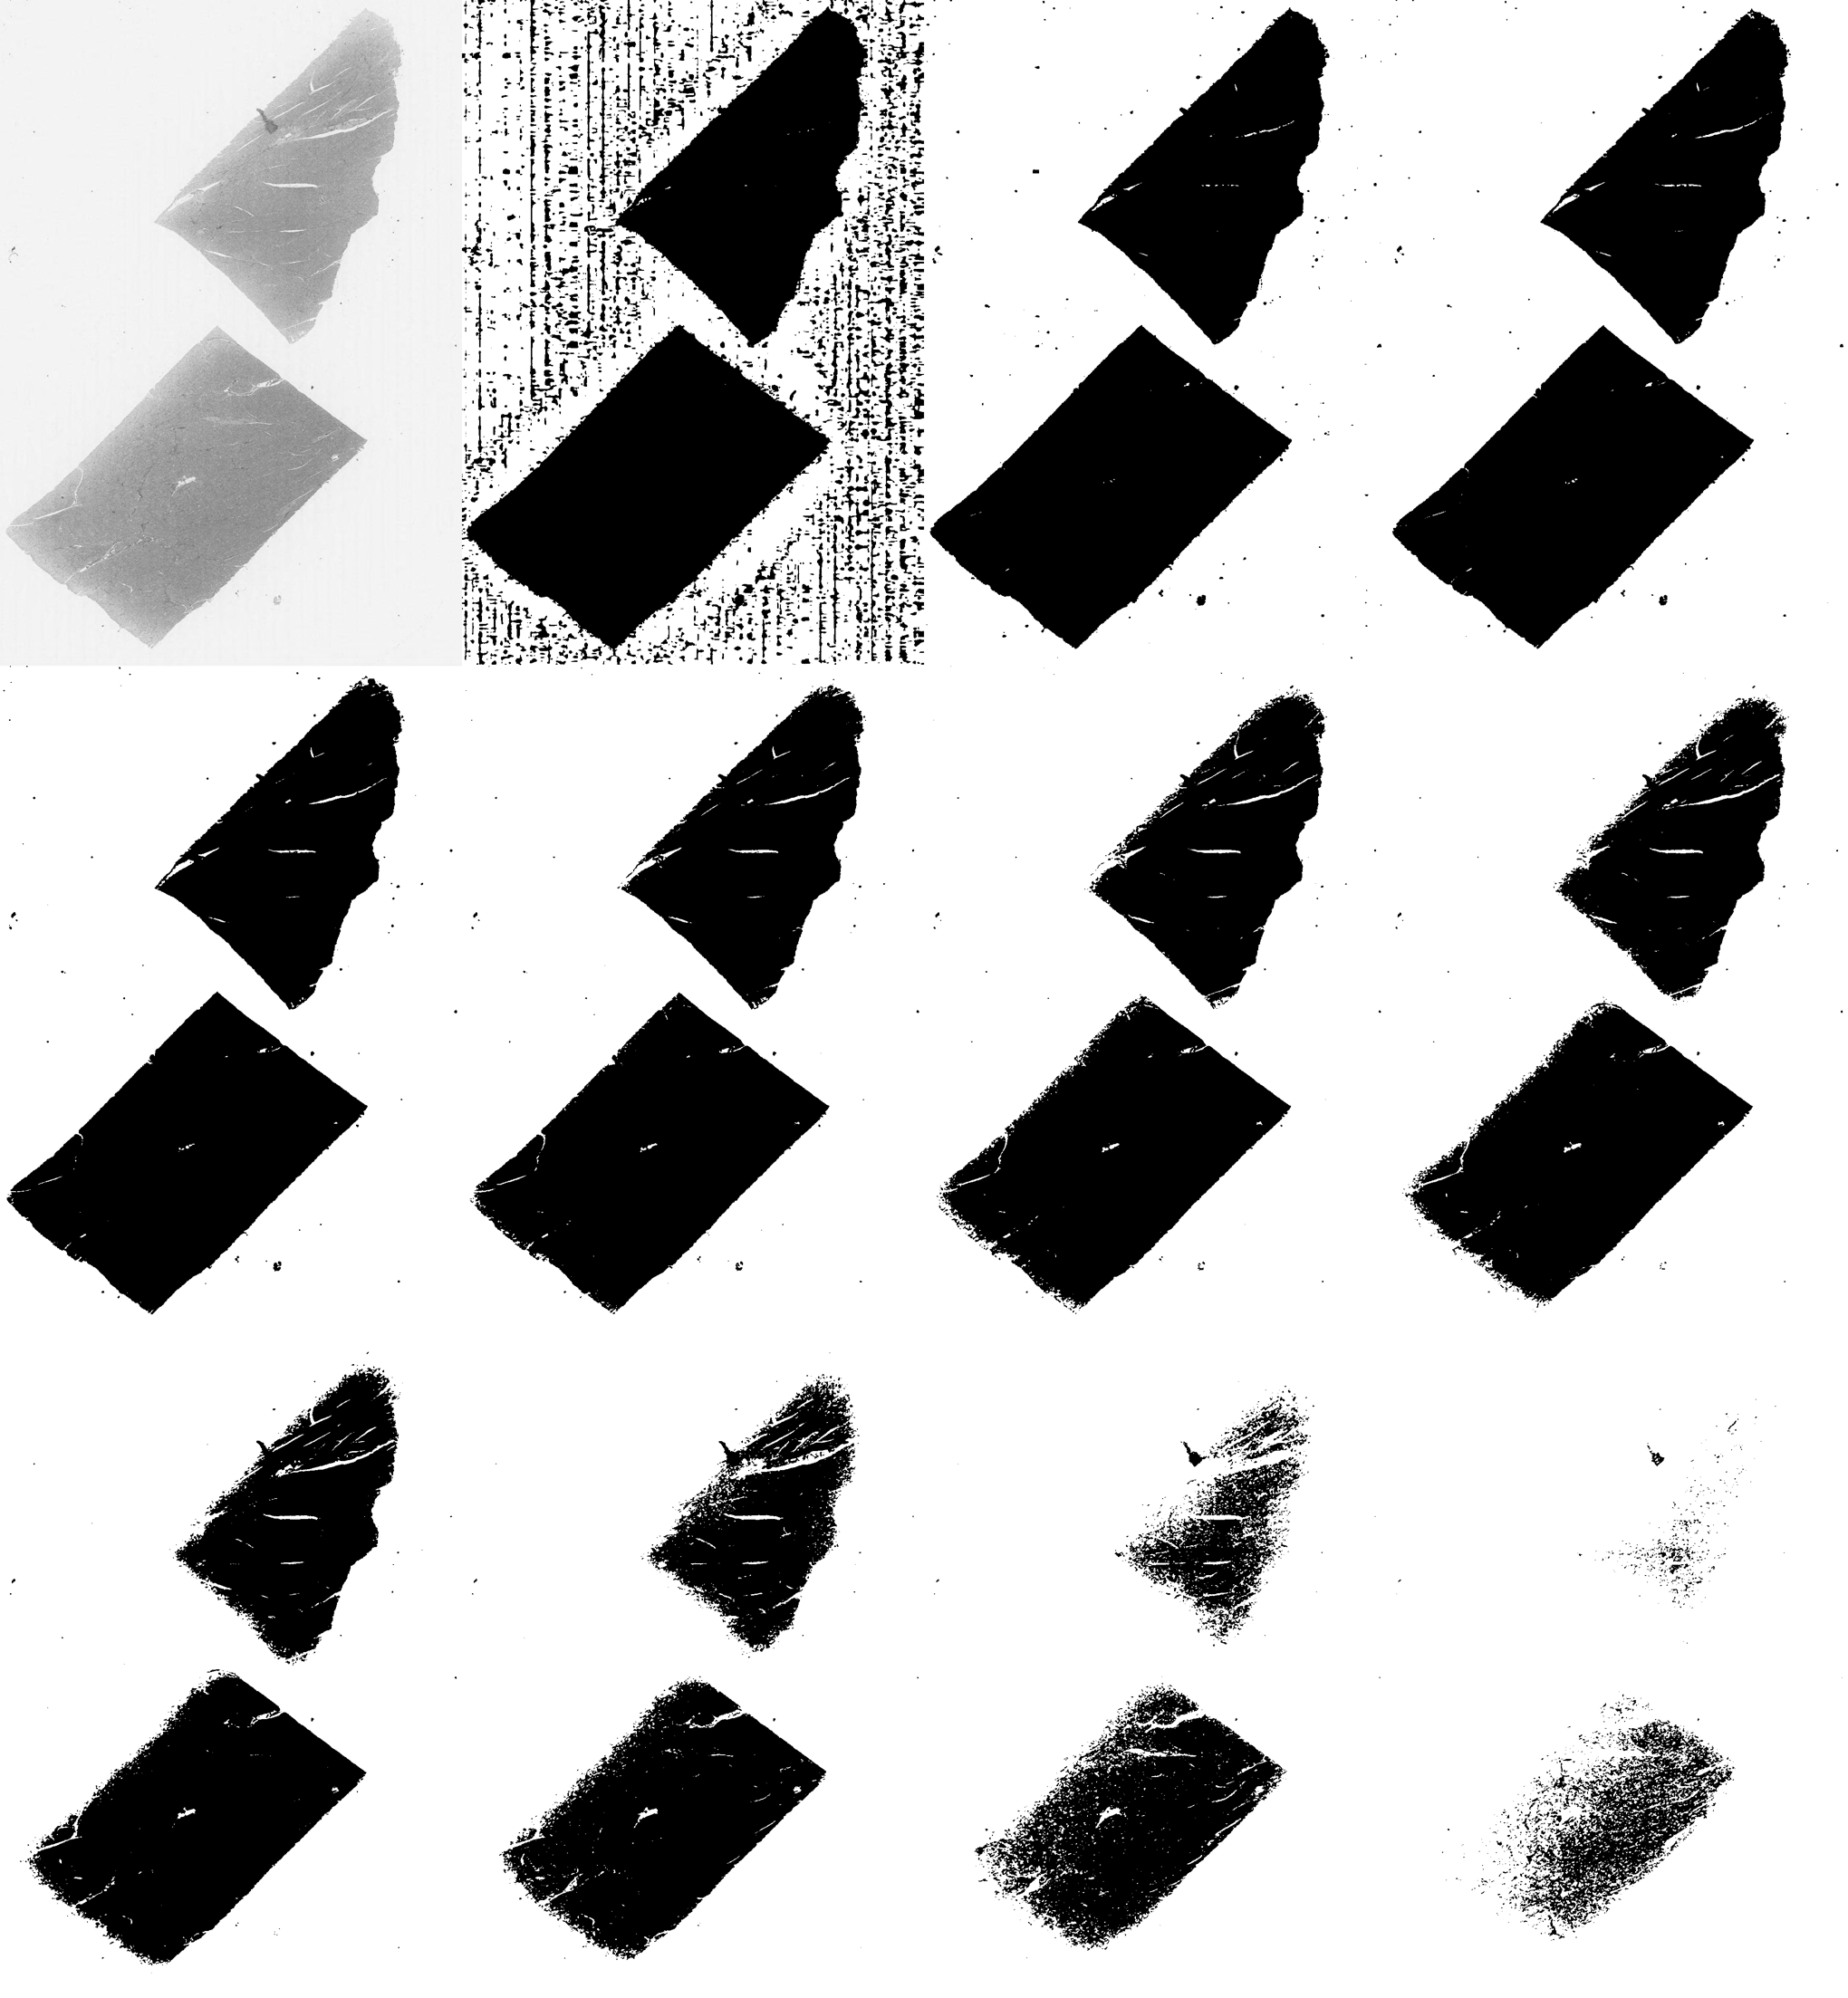

In [7]:
cutter.try_thresholds()

There seems to be a few nice values for `sat_thresh` but let's select `20` and define th `Cutter()` again.

In [8]:
cutter = hp.Cutter(
    slide_path=slide_path,
    width=1024,
    overlap=0.2,
    downsample=16,
    max_background=0.6,
    sat_thresh=20       #ADD THIS!
)

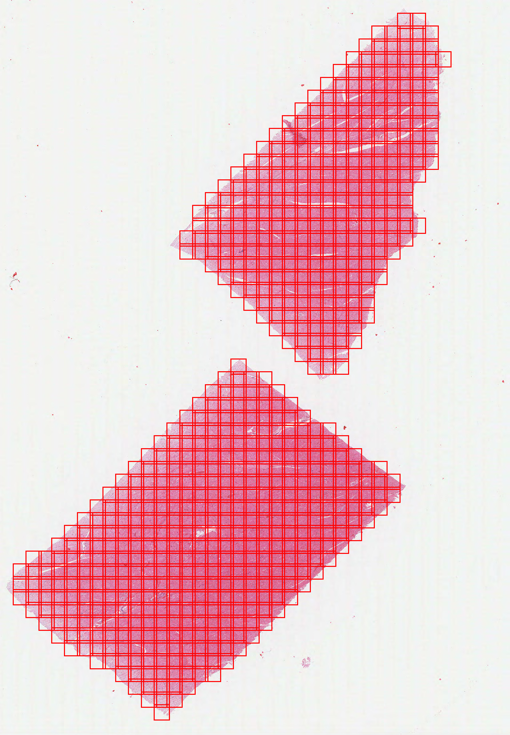

In [9]:
cutter.plot_tiles()

Nice! Now we have detected all correct tiles nicely and we're ready to save the images.

In [11]:
metadata = cutter.cut(parent_dir='/data/test/')

heart: 100%|████████████████████| 726/726 [01:08<00:00, 10.63it/s]


Now all tiles are saved inside the defined directory along with the metadata and annotated thumbnail!

In [12]:
!tree /data/test --filelimit 10

/data/test
└── heart
    ├── images [726 entries exceeds filelimit, not opening dir]
    ├── metadata.csv
    ├── summary.txt
    └── thumbnail.jpeg

2 directories, 3 files


## Preprocessing

This step has drove me to cry in the corner of our small office way too many times. To minimize crying, during the saving process, selected preprocessing metrics are saved to the `metadata.csv` file along with the coordinates, image path etc.

With these metrics and some other features in `histoprep` it's easy to detect tiles with...
- artifacts (pen markings, hairs etc.)
- data loss (completely black or white pixels)
- really blurry areas

**The slide we just cut is actually really nice so I'm going to present the preprocessing steps with another slide selected from a recent [Kaggle competition](https://www.kaggle.com/c/prostate-cancer-grade-assessment/overview) for prostate cancer grading.**

In [13]:
cutter = hp.Cutter(
    slide_path='/data/COHORTS/PANDA/train_images/0b73719f81c77051bb4b0ece8647a48e.tiff',
    width=512,
    overlap=0.25,
    downsample=16,
    max_background=0.6,
    sat_thresh=15
)
metadata = cutter.cut('/data/test')
metadata.head(5)

0b73719f81c77051bb4b0ece8647a48e: 100%|████████████████████| 272/272 [00:04<00:00, 58.50it/s]


path  \
0  /data/test/0b73719f81c77051bb4b0ece8647a48e/im...   
1  /data/test/0b73719f81c77051bb4b0ece8647a48e/im...   
2  /data/test/0b73719f81c77051bb4b0ece8647a48e/im...   
3  /data/test/0b73719f81c77051bb4b0ece8647a48e/im...   
4  /data/test/0b73719f81c77051bb4b0ece8647a48e/im...   

                         slide_name    x     y  width  background_estimate  \
0  0b73719f81c77051bb4b0ece8647a48e    0  3840    512             0.150391   
1  0b73719f81c77051bb4b0ece8647a48e    0  4224    512             0.061523   
2  0b73719f81c77051bb4b0ece8647a48e    0  4608    512             0.151367   
3  0b73719f81c77051bb4b0ece8647a48e  384  3840    512             0.305664   
4  0b73719f81c77051bb4b0ece8647a48e  384  4224    512             0.000000   

   background    sharpness  black_pixels  white_pixels  ...  hue_0.99  \
0    0.200699   630.896973           0.0      0.044342  ...     163.0   
1    0.094582   963.898865           0.0      0.090145  ...     157.0   
2    0.189533  1006.446777           0.0      0.153625  ...     154.0   
3    0.357849   689.427734           0.0      0.000298  ...     174.0   
4    0.026596   771.093506           0.0      0.000061  ...     175.0   

   val_0.01  val_0.05  val_0.1  val_0.25  val_0.5  val_0.75  val_0.9  \
0      54.0      64.0     74.0     106.0    158.0     182.0    212.0   
1      28.0      34.0     38.0      41.0     47.0      69.0     95.0   
2      30.0      39.0     41.0      43.0     52.0      86.0    157.0   
3      61.0      83.0     97.0     133.0    192.0     220.0    233.0   
4      31.0      40.0     52.0      97.0    172.0     216.0    228.0   

   val_0.95  val_0.99  
0     224.0     234.0  
1     110.0     149.0  
2     187.0     212.0  
3     241.0     253.0  
4     235.0     249.0  

[5 rows x 28 columns]

In this example, the cancer areas are marked with a pen. These pen markings are detected as tissue, and saved along with actual tissue.

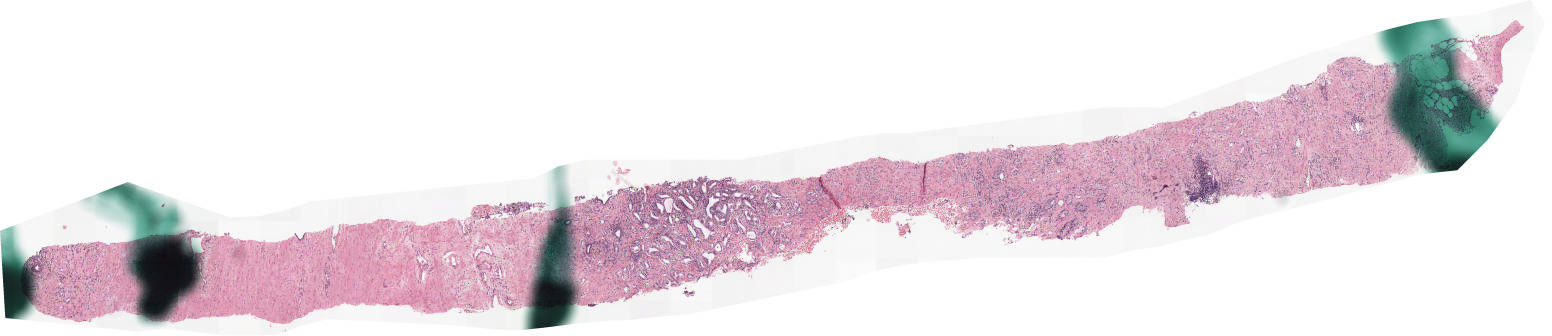

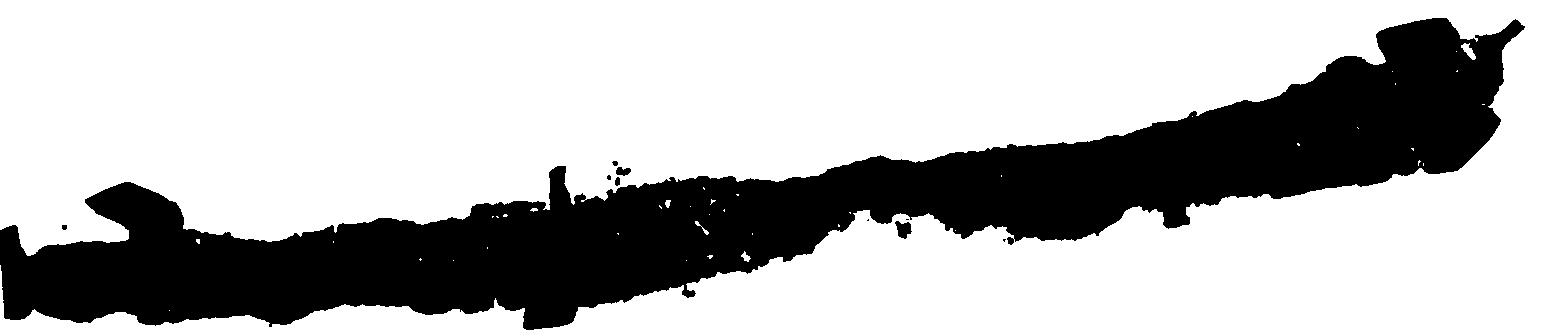

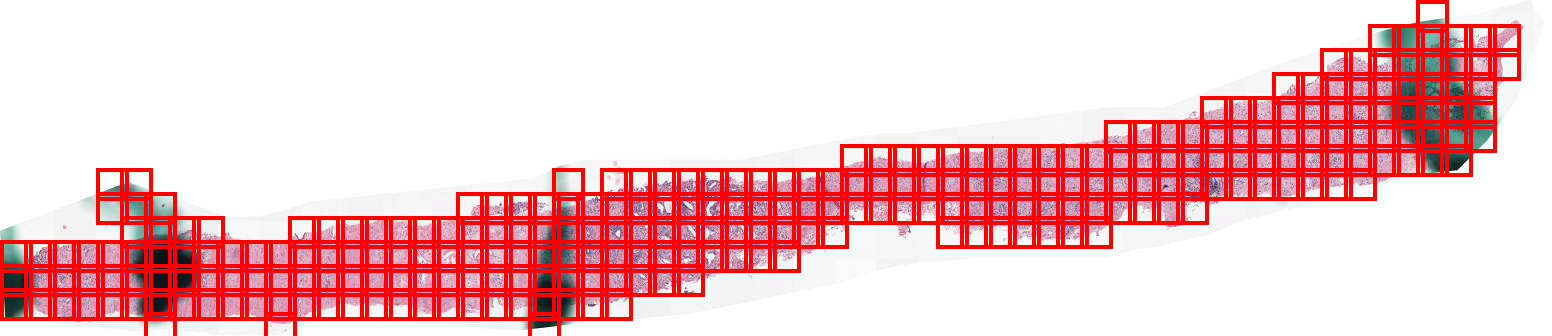

In [2]:
display(cutter.plot_thumbnail())
display(cutter.plot_tissue_mask())
display(cutter.plot_tiles())

### Artifacts

Let's see how to discard those tiles that actually contain pen markings.

In histological images, the HSV transformation is super useful! HSV stands for Hue, Saturation and Value (ie. brightness). Saturation was already used to detect tissue and now hue and brightness can be used to detect artifacts.

In the metadatata, `hue_0.*` and `val_0.*` columns tell you the quantiles of the `hue` and `val` values for the tissue areas in the tile. Even a small hair should be detectable with `hue_0.01` and `val_0.01` columns as deviations from the norm. If you're willing to pass small artifacts you can select a higher quantile.

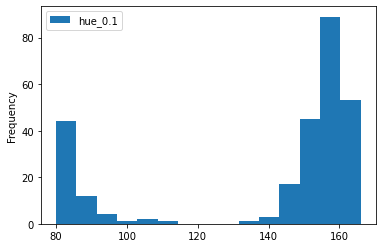

In [12]:
metadata.plot.hist(y='hue_0.1',bins=15);

In the histogram we can clearly see two distributions. Even though we speculate that the `hue_0.5` column detects what we want, we should always peek what the tiles look like for a certain value! This can be done with either
- `plot_tiles()`, which plots a random selection of tiles from the passed dataframe
- `plot_on_thumbnail()`, which plots all the tiles in a dataframe to the thumbnail.

We'll use the latter now!

In [13]:
artifacts = metadata[metadata['hue_0.1'] < 120]

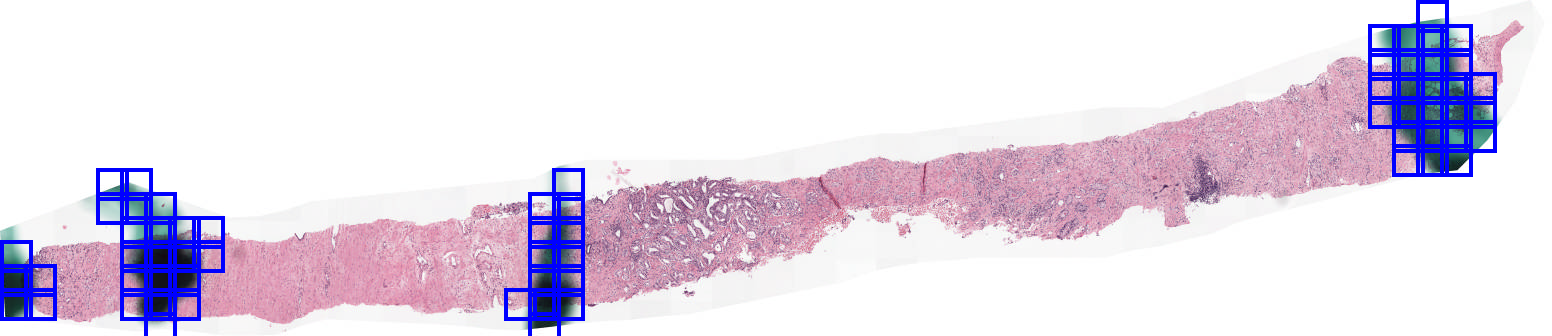

In [15]:
hp.metadata.plot_on_thumbnail(
    dataframe=artifacts,
    thumbnail=cutter.plot_thumbnail(),
    downsample=16
)

That was easy! Now we can just remove the tiles with artifacts by simply slicing the `metadata` dataframe correctly.

### Sharpness

Now let's also quickly check for blurry tiles. Sharpness value is generated by dividing running a sliding window over the slide (`tile_width/2` with `0.5` overlap) and reporting the maximum laplacian variance of the windows.

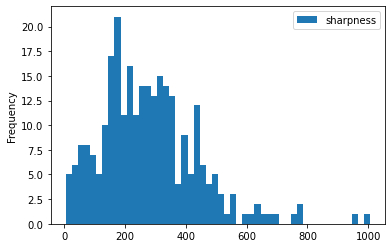

In [20]:
metadata.plot.hist(y='sharpness',bins=50);

As we can see there seems to be some slides with smaller sharpness values. Let's take a closer look!

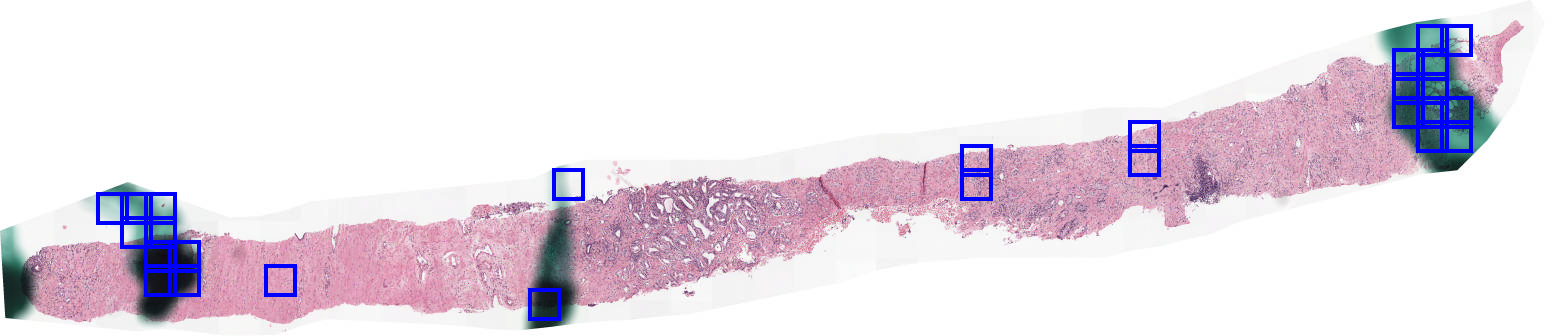

In [23]:
hp.metadata.plot_on_thumbnail(
    dataframe=metadata[metadata['sharpness'] < 80],
    thumbnail=cutter.plot_thumbnail(),
    downsample=16
)

Most of the blurry tiles are in the artifacts we already detected, but there seems to be a few other tiles with smaller sharpness values. Let's take a look with the `plot_tiles` function.

SHARPNESS:
 24.673  4.263   71.455  18.279  19.547  11.087  4.352   24.709 
 43.356  76.011  34.97   65.703  60.42   76.295  57.793  70.139 
 63.17   55.611  61.423  48.039  41.908  38.262  75.302  65.891 
 69.447  63.721  60.184 


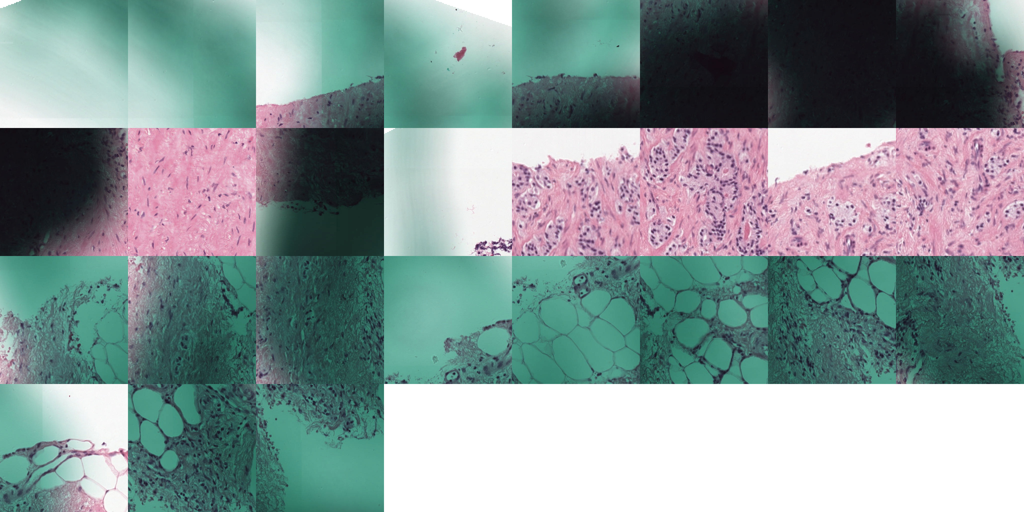

In [26]:
hp.metadata.plot_tiles(
    dataframe=metadata[metadata['sharpness'] < 80],
    rows=5,cols=8,
    title_column='sharpness'
)

The threshold of 80 was a bit too high as the non-artifact tiles aren't really that blurry. I wouldn't remove any tiles due to them being blurry.

### Data loss

Even scanners make mistakes and sometimes there are areas of data loss in the slides. These can be detected with either `white_pixels` or `black_pixels` columns, depending on whether you consider values `0` or `255`to represent data_loss.

# Downsample and tissue detection accuracy 

As some of you may have noticed, the metadata contains columns `background_estimate` and `background`. The first one is the thumbnail based background percentage and the second one is the actual bakcground percentage calculated during image saving.

There is a clear correlation between the selected `downsample` and background estimation accuracy as well as the time it takes to filter background tiles.

Let's take a closer look by trying different downsamples.

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

slide_path = '/data/heart.svs'

In [38]:
estimates = []
truth = []
downsamples = [4,8,16,32,64,128]
for downsample in downsamples:
    cutter = hp.Cutter(
        slide_path=slide_path,
        width=1024,
        downsample=downsample,
        max_background=0.999,
        sat_thresh=20
    )
    metadata = cutter.cut('/data/test',overwrite=True)
    estimates.append(metadata['background_estimate'].tolist())
    truth.append(metadata['background'].tolist())

heart: 100%|████████████████████| 546/546 [00:41<00:00, 13.08it/s]


Yea if the slide doesn't have the downsample you want, you can generate it yourself!

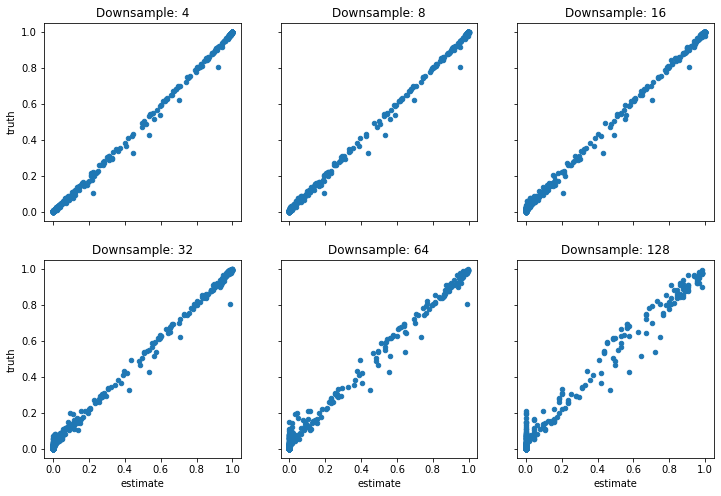

In [100]:
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(12, 8),
    squeeze=False,sharey=True,sharex=True
)
for i,var in enumerate(downsamples):
    row = i//3
    col = i
    if i>2:
        col=i-3
    results[results.downsample == var].plot.scatter(
        y='truth',x='estimate',title=f'Downsample: {var}',
        ax=axes[row,col]
    )

As you can see from the plot, the estimated background isn't that far from the truth when using `downsample<=16`. You could select a higher downsample to make the filtering faster. With higher downsamples, you just have to accept that the estimate isn't that accurate. In these situations, you should purposefully select a higher `max_background` argument and during the preprocessing step, discard tiles based on the `background` column.